# Multilabel Logistic Regression

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from metrics.Multilabel_classification_metrics import Precision, Accuracy, Recall, F1Measure, Hamming_Loss

import pickle
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, accuracy_score

## Load pickles objects

In [2]:
# Dataframe
path_df = "../Pickles/multilabel_binarizer.pickle"
with open(path_df, 'rb') as data:
    multilabel_binarizer = pickle.load(data)

# features_train
path_features_train = "../Pickles/features_train.pickle"
with open(path_features_train, 'rb') as data:
    features_train = pickle.load(data)

# labels_train
path_labels_train = "../Pickles/labels_train.pickle"
with open(path_labels_train, 'rb') as data:
    labels_train = pickle.load(data)

# features_test
path_features_test = "../Pickles/features_test.pickle"
with open(path_features_test, 'rb') as data:
    features_test = pickle.load(data)

# labels_test
path_labels_test = "../Pickles/labels_test.pickle"
with open(path_labels_test, 'rb') as data:
    labels_test = pickle.load(data)

In [3]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

In [4]:
clf.fit(features_train, labels_train)

OneVsRestClassifier(estimator=LogisticRegression())

In [5]:
y_pred = clf.predict(features_test)

In [6]:
print(y_pred[95])
print(labels_test[95])

[0 0 0 1 0 0 1 0 0 0 0]
[0 0 0 1 0 0 1 1 0 0 0]


In [7]:
multilabel_binarizer.inverse_transform(y_pred)[95]

('Fiction', 'Novel')

In [8]:
F1Measure(labels_test, y_pred)

0.37711966816904985

In [9]:
# predict probabilities
y_pred_prob = clf.predict_proba(features_test)

In [10]:
y_pred_prob

array([[0.17025228, 0.01804393, 0.02757964, ..., 0.09974962, 0.04366356,
        0.12955964],
       [0.1957009 , 0.02436385, 0.03632672, ..., 0.11369624, 0.01718376,
        0.03261148],
       [0.10772052, 0.01576703, 0.12868155, ..., 0.64971621, 0.02518049,
        0.05908847],
       ...,
       [0.11018997, 0.02143094, 0.11367956, ..., 0.41672578, 0.01943817,
        0.05063943],
       [0.03500998, 0.07267343, 0.09565117, ..., 0.13818755, 0.07833327,
        0.01844563],
       [0.15852814, 0.06843591, 0.04185563, ..., 0.32401638, 0.13340339,
        0.09657715]])

In [47]:
def findBestThresholdForLabel(predicted, expected):
    thresholds = np.arange(0.0,1.0, 0.005)
    best_thresh = 0.0
    best_accuracy = 0.0
    for t in thresholds:
       y_pred_new = (predicted >= t).astype(int)
       best_accuracy_cur = accuracy_score(expected, y_pred_new)
       if best_accuracy_cur >= best_accuracy:
           best_thresh = t
           best_accuracy = best_accuracy_cur
    return best_thresh
       
def getBestThresholdsForLables(predicted_list, expected_list):
    array_of_thresholds = []
    for i in range(0, len(predicted_list[0])):
        predicted_column = getColumn(predicted_list, i)
        expected_column = getColumn(expected_list, i)
        array_of_thresholds.append(findBestThresholdForLabel(predicted_column, expected_column))
    return array_of_thresholds

def getColumn(list_of_labels, index) :
    return [l[index] for l in list_of_labels]

In [50]:
list_of_thresholds = getBestThresholdsForLables( y_pred_prob, labels_test)

In [51]:
for key,values in enumerate(y_pred_prob):
    for key1,values1 in enumerate(values):
        y_pred_prob[key][key1] = int(values1 >= list_of_thresholds[key1])
        

In [53]:
# evaluate performance
F1Measure(labels_test, y_pred_prob)

0.4086230788611743

In [56]:
# Exact Match Ratio:
accuracy_score(labels_test, y_pred_prob)

0.15196942974720754

In [57]:
Accuracy(labels_test, y_pred_prob)

0.34353181601858845

In [58]:
Precision(labels_test, y_pred_prob)

0.4065773634556706

In [59]:
Recall(labels_test, y_pred_prob)

0.48265726043503815

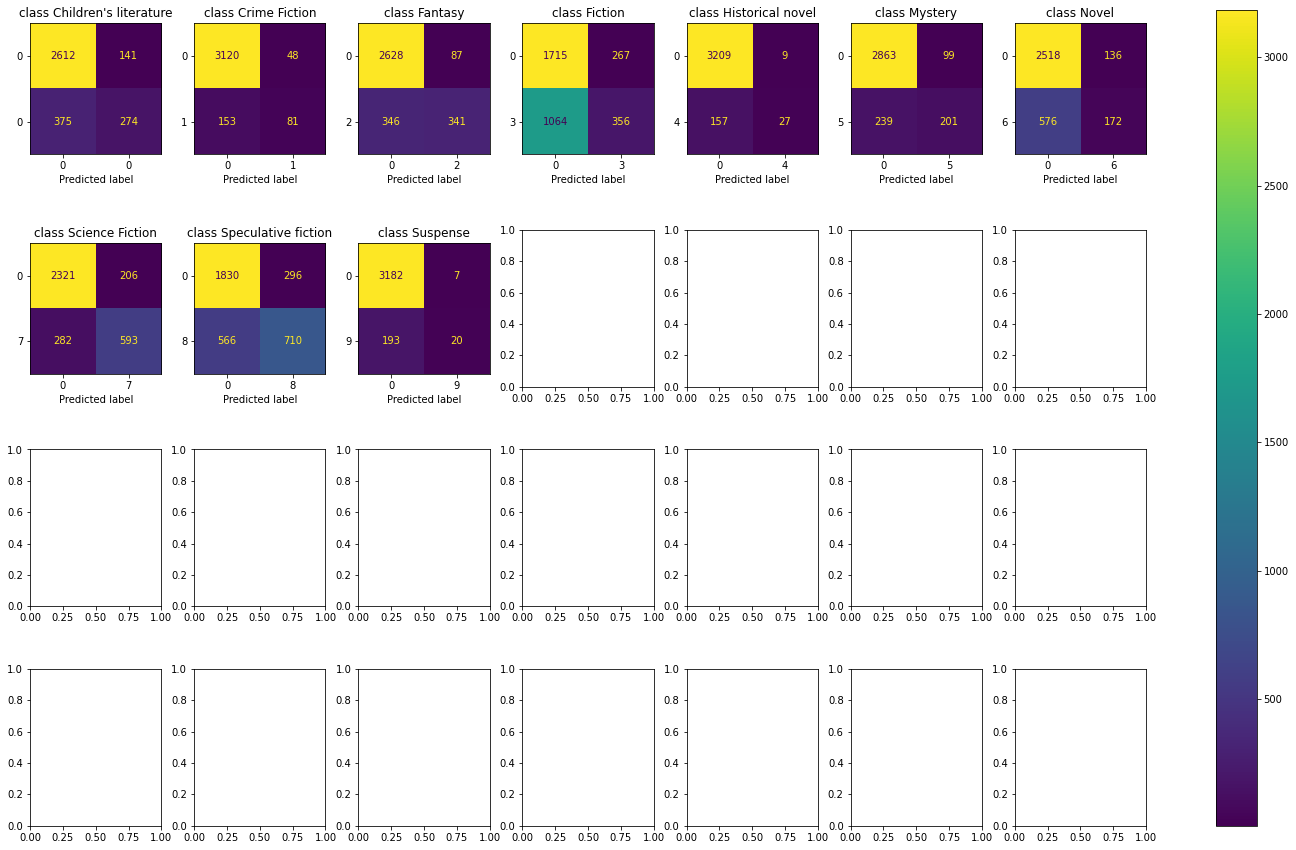

In [60]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
classes = multilabel_binarizer.classes_
f, axes = plt.subplots(4, 7, figsize=(25, 15))
axes = axes.ravel()
for i in range(10):
    disp = ConfusionMatrixDisplay(confusion_matrix(labels_test[:, i],
                                                   y_pred_prob[:, i]),
                                  display_labels=[0, i])
    disp.plot(ax=axes[i], values_format='.4g')
    disp.ax_.set_title(f'class {classes[i]}')
    disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.25, hspace=0.4)
f.colorbar(disp.im_, ax=axes)
plt.show()